In [26]:
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER') or '/home/fne23_stjarnholm/master-project'}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results = []

result_folders = run_tools.get_all_result_dirs()

# Loop over each run number and get the run settings as well as the k-effective
for result_folder in result_folders:
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    results.append(result)

In [27]:
# PLOT SETTINGS:
FAST_REACTOR = False

folder_name = f"plots-FAST_REACTOR={FAST_REACTOR}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-FAST_REACTOR={FAST_REACTOR}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filter for FAST_REACTOR
df = df[df["FAST_REACTOR"] == FAST_REACTOR]

if df.empty:
    raise Exception("No results found!")

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed
48,0.764276,0.039195,../results/RUNDATA_R2_49,True,100,10,50,1.675859e+09,1.675859e+09,5.315
49,0.751309,0.015845,../results/RUNDATA_R2_50,True,100,30,50,1.675859e+09,1.675859e+09,4.798
50,0.721910,0.008405,../results/RUNDATA_R2_51,True,100,100,50,1.675859e+09,1.675859e+09,5.045
51,0.732098,0.004637,../results/RUNDATA_R2_52,True,100,300,50,1.675859e+09,1.675859e+09,5.710
52,0.727187,0.002466,../results/RUNDATA_R2_53,True,100,1000,50,1.675859e+09,1.675859e+09,8.256


In [28]:
# pivot the dataframe from long to wide form
pivoted_df_k_eff = df.pivot(index='particle_count', columns='active_batch_count', values='k-eff')
pivoted_df_k_eff_std = df.pivot(index='particle_count', columns='active_batch_count', values='k-eff-std')
pivoted_df_t_elapsed = df.pivot(index='particle_count', columns='active_batch_count', values='t_elapsed')

df["rel_err_k-eff-std"] = 100 * df["k-eff-std"] / df["k-eff"]
pivoted_df_rel_err_k_eff_std = df.pivot(index='particle_count', columns='active_batch_count', values='rel_err_k-eff-std')

df["rho"] = (df["k-eff"] - 1) / df["k-eff"]
df["rho-std"] = np.sqrt((df["k-eff-std"] / (df["k-eff"] - 1))**2 + (df["k-eff-std"] / df["k-eff"])**2)

df["rho-pcm"] = 1e5 * df["rho"]
df["rho-std-pcm"] = 1e5 * df["rho-std"]

pivoted_df_rho_pcm = df.pivot(index='particle_count', columns='active_batch_count', values='rho-pcm')
pivoted_df_rho_std_pcm = df.pivot(index='particle_count', columns='active_batch_count', values='rho-std-pcm')

df["rel-err_rho-std"] = np.abs(100 * df["rho-std"] / df["rho"])
pivoted_df_rel_err_rho_std = df.pivot(index='particle_count', columns='active_batch_count', values='rel-err_rho-std')

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,rel_err_k-eff-std,rho,rho-std,rho-pcm,rho-std-pcm,rel-err_rho-std
48,0.764276,0.039195,../results/RUNDATA_R2_49,True,100,10,50,1.675859e+09,1.675859e+09,5.315,5.128429,-0.308428,0.174006,-30842.769433,17400.564040,56.416996
49,0.751309,0.015845,../results/RUNDATA_R2_50,True,100,30,50,1.675859e+09,1.675859e+09,4.798,2.109018,-0.331010,0.067115,-33100.965582,6711.453199,20.275702
50,0.721910,0.008405,../results/RUNDATA_R2_51,True,100,100,50,1.675859e+09,1.675859e+09,5.045,1.164211,-0.385214,0.032387,-38521.358454,3238.728913,8.407619
51,0.732098,0.004637,../results/RUNDATA_R2_52,True,100,300,50,1.675859e+09,1.675859e+09,5.710,0.633418,-0.365937,0.018432,-36593.724011,1843.203758,5.036940
52,0.727187,0.002466,../results/RUNDATA_R2_53,True,100,1000,50,1.675859e+09,1.675859e+09,8.256,0.339107,-0.375162,0.009654,-37516.212196,965.411219,2.573317


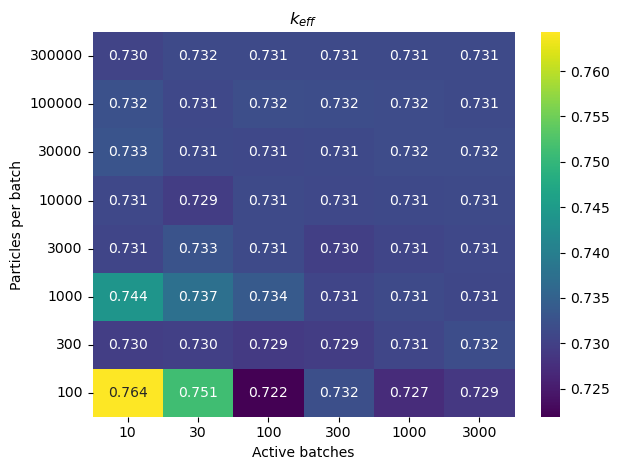

In [29]:
ax = sns.heatmap(pivoted_df_k_eff, annot=True, fmt=".3f", cmap='viridis')
ax.invert_yaxis()
plt.title("$k_{eff}$")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "k_eff"))

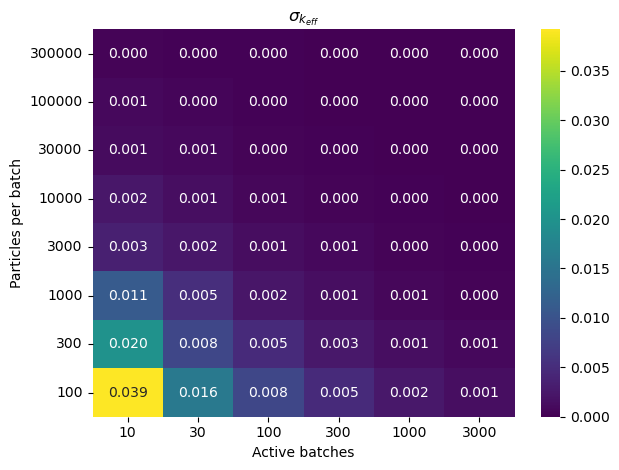

In [30]:
ax = sns.heatmap(pivoted_df_k_eff_std, annot=True, fmt=".3f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$\sigma_{k_{eff}}$")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "k_eff_std"))

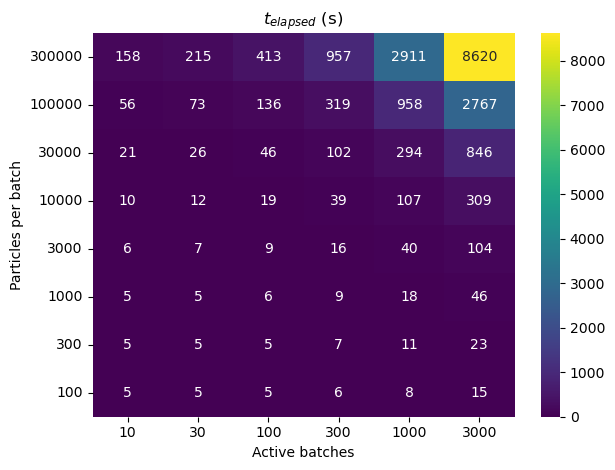

In [31]:
ax = sns.heatmap(pivoted_df_t_elapsed, annot=True, fmt=".0f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$t_{elapsed}$ (s)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "t_elapsed"))

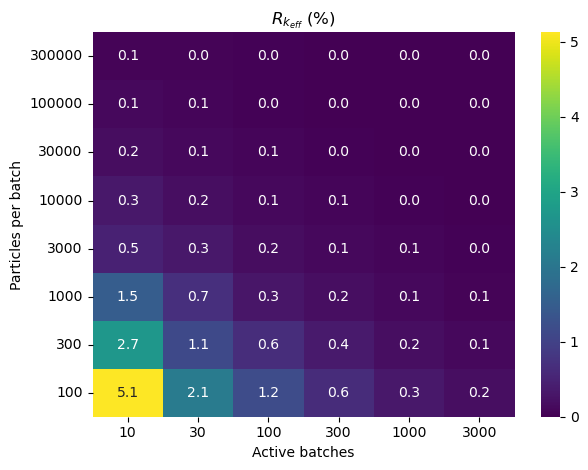

In [32]:
ax = sns.heatmap(pivoted_df_rel_err_k_eff_std, annot=True, fmt=".1f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title("$R_{k_{eff}}$ (%)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rel-err-k_eff_std"))

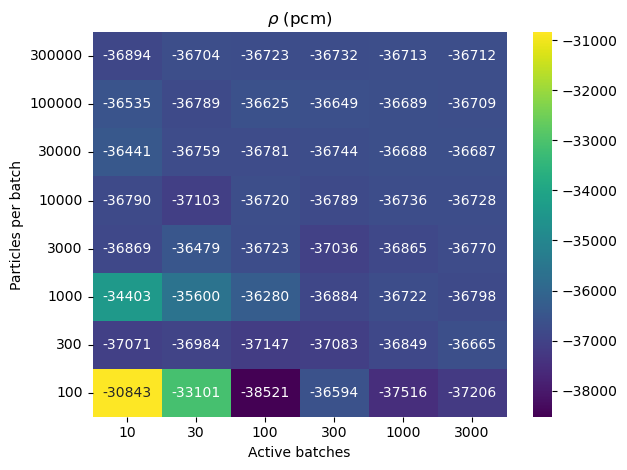

In [33]:
ax = sns.heatmap(pivoted_df_rho_pcm, annot=True, fmt=".0f", cmap='viridis')
ax.invert_yaxis()
plt.title(r"$\rho$ (pcm)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rho_pcm"))

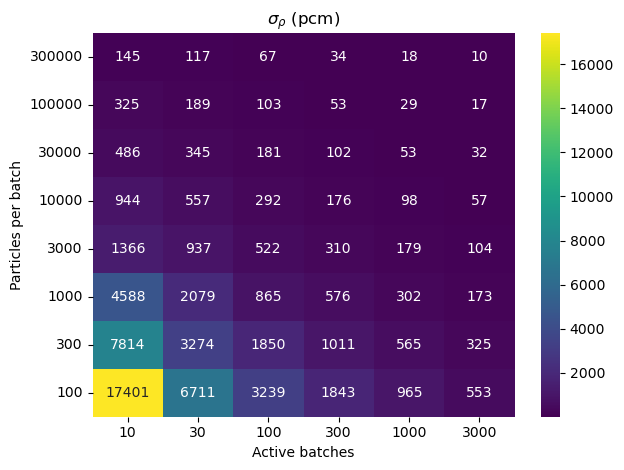

In [34]:
ax = sns.heatmap(pivoted_df_rho_std_pcm, annot=True, fmt=".0f", cmap='viridis')
ax.invert_yaxis()
plt.title(r"$\sigma_{\rho}$ (pcm)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rho_std_pcm"))

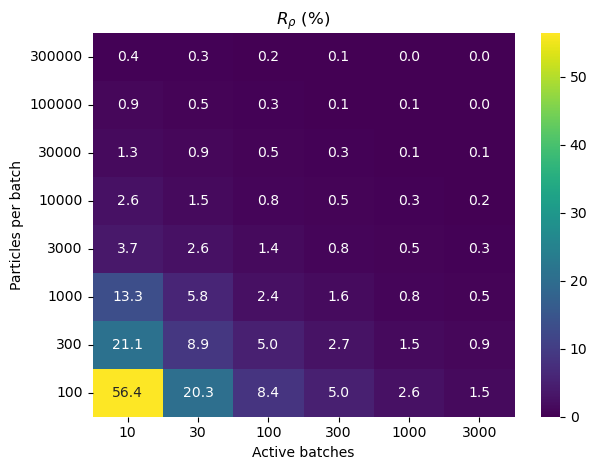

In [35]:
ax = sns.heatmap(pivoted_df_rel_err_rho_std, annot=True, fmt=".1f", cmap='viridis', vmin=0)
ax.invert_yaxis()
plt.title(r"$R_{\rho}$ (%)")
plt.xlabel("Active batches")
plt.ylabel("Particles per batch")
plt.tight_layout()
plt.savefig(get_filename("heatmap", "rel-err-rho_std"))